Several people have reported a discrepancy between CV and LB scores. The main idea behind this kernel is to have a quick and dirty check: how different are the distributions of the classes between training and test sets? The approach I use is adversarial validation:

http://fastml.com/adversarial-validation-part-one/



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.metrics import cohen_kappa_score

import numpy as np
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

from PIL import Image


import time
import torchvision
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
import os

device = torch.device("cuda:0")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [6]:
# settings
bs = 64 
sz = 224

In [7]:
# # Making pretrained weights work without needing to find the default filename
# if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
#         os.makedirs('/tmp/.cache/torch/checkpoints/')
# !cp '../data/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

# Data

The point of this block is to combine the training and test data into a single data frame, which can subsequently be used in our pipeline.

In [83]:
# training images
base_image_dir = os.path.join('..', 'data/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df['is_test'] = 0
df.drop('diagnosis', axis = 1, inplace = True)

df1 = df.copy()

In [84]:
df1.head()

,path,is_test
0,../data/train_images/274f5029189b.png,0
1,../data/train_images/43e9c66eb0f3.png,0
2,../data/train_images/05b1bb2bdb81.png,0
3,../data/train_images/a14bbd9a583e.png,0
4,../data/train_images/bda7ff3b1562.png,0


In [10]:
# test images
base_image_dir = os.path.join('..', 'data/')
train_dir = os.path.join(base_image_dir,'test_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'test.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df['is_test'] = 1
df2 = df.copy()

In [11]:
df2.head()

,path,is_test
0,../data/test_images/4a51e72940f2.png,1
1,../data/test_images/f320b5f7f5b5.png,1
2,../data/test_images/22c7ca4863ee.png,1
3,../data/test_images/17bed9f69d84.png,1
4,../data/test_images/5ad2ca6d422f.png,1


In [12]:
df_total = pd.concat([df1,df2], axis =0 )
df_total = df_total.sample(frac=1).reset_index(drop=True) 
del df1, df2

In [13]:
df_total.head()

,path,is_test
0,../data/train_images/1006345f70b7.png,0
1,../data/test_images/33a0fb5161e1.png,1
2,../data/train_images/bed8296c8dfe.png,0
3,../data/train_images/ddb222ff7c1d.png,0
4,../data/test_images/5450ee92dfc6.png,1


In [22]:
# add cv folds indices (yes, i know it's ugly :-)
kf = KFold(n_splits=5)

df_total['fold_id'] = -1

for (nf, (train_index, test_index)) in enumerate(kf.split(df_total)):
    df_total['fold_id'][test_index] = nf

# df_total's fold_id is used categoried into cases to be used as validation for each fold, like
# for fold=0, those with fold_id==0 will be validation set, rest will be in train set :)

/home/ags/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [23]:
df_total['fold_id'].value_counts()

3    1118
2    1118
1    1118
4    1118
0    1118
Name: fold_id, dtype: int64

In [15]:
df_total.head()

,path,is_test,fold_id
0,../data/train_images/1006345f70b7.png,0,0
1,../data/test_images/33a0fb5161e1.png,1,0
2,../data/train_images/bed8296c8dfe.png,0,0
3,../data/train_images/ddb222ff7c1d.png,0,0
4,../data/test_images/5450ee92dfc6.png,1,0


# Model

Loop over folds - check performance for each

In [24]:
res = np.zeros((5,1))

In [25]:
for ii in range(0, 5):
    
    # create this split for training / validation 
    df = df_total.copy()
    df['is_valid'] = (df['fold_id'] == ii) + 0
    df.drop('fold_id', axis = 1, inplace = True)
    
    # create the data object
    tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
    src = (ImageList.from_df(df=df,path='./',cols='path') 
        .split_from_df() 
        .label_from_df(cols='is_test') 
      )
    data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros')
        .databunch(bs=bs,num_workers=4)
        .normalize(imagenet_stats)   
       )
    
    # train a model for this fold - no optimization
    learn = cnn_learner(data, base_arch = models.resnet50)
    learn.unfreeze()
    learn.fit_one_cycle(1, max_lr = slice(1e-6,1e-3))
    
    # evaluate performance
    img = learn.data.valid_dl
    xpred = learn.get_preds(img)
    xscore = roc_auc_score(xpred[1],xpred[0][:,1])
    print('fold '+str(ii) + ': ' + str(np.round(xscore, 4)))

    res[ii] = xscore
    

fold 4: 0.9196


As can be seen from the results above (each fold has AUC > 0.9), even with a clearly underfitting model (validation loss < training loss) we can quite accurately distinguish the training and test sets. This means garden variety random split just won't do the job :-(

In [11]:
print(res)

[[0.901727]
 [0.914371]
 [0.920532]
 [0.910776]
 [0.910139]]


In [32]:
xpred[0].shape, xpred[1].shape

(torch.Size([4472, 2]), torch.Size([4472]))

In [55]:
img = learn.data.train_dl
xpred = learn.get_preds(img)

In [56]:
ypred = xpred[0][:, 1]

(array([2243.,  536.,  240.,  149.,   69.,   45.,   41.,   17.,   50., 1082.]),
 array([3.588018e-04, 1.003228e-01, 2.002869e-01, 3.002509e-01, 4.002149e-01, 5.001789e-01, 6.001430e-01, 7.001070e-01,
        8.000710e-01, 9.000350e-01, 9.999990e-01], dtype=float32),
 <a list of 10 Patch objects>)

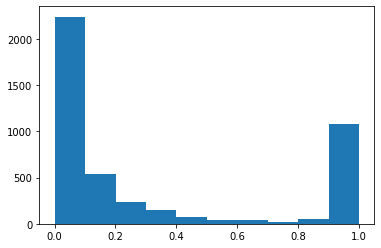

In [58]:
plt.hist(ypred)

In [103]:
ypred_test = ypred > 0.4

In [104]:
indices = np.where(ypred_test==1)[0]

In [111]:
indices.shape

(1304,)

In [106]:
ypred_test_paths = learn.data.train_dl.dl.dataset.x.items[indices]

In [118]:
df1.head(), df1.shape

(                                    path  is_test
 0  ../data/train_images/274f5029189b.png        0
 1  ../data/train_images/43e9c66eb0f3.png        0
 2  ../data/train_images/05b1bb2bdb81.png        0
 3  ../data/train_images/a14bbd9a583e.png        0
 4  ../data/train_images/bda7ff3b1562.png        0, (3662, 2))

In [108]:
paths = [x[2:] for x in ypred_test_paths]

In [112]:
paths

['../data/test_images/33a0fb5161e1.png',
 '../data/test_images/5450ee92dfc6.png',
 '../data/test_images/76a1bc72e45f.png',
 '../data/test_images/12411c037cfb.png',
 '../data/test_images/e7557ee92477.png',
 '../data/test_images/2cdd4f04b914.png',
 '../data/test_images/01e4d86b3a30.png',
 '../data/test_images/4df7349f0806.png',
 '../data/test_images/51f57fb32840.png',
 '../data/test_images/acd52452b9a2.png',
 '../data/test_images/41cc795c4acd.png',
 '../data/test_images/31e9b7060c33.png',
 '../data/test_images/2c754e336552.png',
 '../data/test_images/84eff2a86662.png',
 '../data/test_images/3ef3056cc3d0.png',
 '../data/train_images/453a1e2754b2.png',
 '../data/test_images/1c62728dd31b.png',
 '../data/test_images/6a27a25f7a0c.png',
 '../data/test_images/6ed9e38a4239.png',
 '../data/test_images/3382ab75cc96.png',
 '../data/test_images/d1e17c1f626f.png',
 '../data/test_images/da763f0c1a0f.png',
 '../data/test_images/6220b43ea8eb.png',
 '../data/test_images/dfff4dd8e2a3.png',
 '../data/train

In [113]:
matching_indices = []
for path in paths:
    matches = df1[df1['path'] == path]
    if matches.shape[0]:
        matching_indices.append(matches.index[0])
len(matching_indices)

123

In [114]:
matching_indices

[1663,
 250,
 596,
 1590,
 3170,
 2361,
 1778,
 3312,
 1253,
 2919,
 2566,
 2269,
 1529,
 1951,
 2418,
 3622,
 1239,
 1484,
 2058,
 3500,
 1414,
 413,
 465,
 3648,
 2498,
 3627,
 3325,
 1135,
 92,
 1564,
 2073,
 291,
 2724,
 1902,
 2878,
 2915,
 915,
 1405,
 1186,
 3030,
 3015,
 862,
 429,
 1051,
 1507,
 900,
 775,
 1128,
 2198,
 1245,
 2904,
 3229,
 1899,
 2013,
 2352,
 1104,
 3100,
 439,
 991,
 2468,
 515,
 2670,
 2730,
 1446,
 2738,
 3093,
 2430,
 1410,
 1554,
 2542,
 1342,
 3493,
 109,
 599,
 1784,
 1244,
 1409,
 401,
 1694,
 2150,
 2436,
 483,
 467,
 1882,
 1949,
 3602,
 2009,
 1016,
 2554,
 3469,
 2652,
 2954,
 55,
 1581,
 409,
 758,
 1360,
 1485,
 2505,
 591,
 3457,
 1987,
 2479,
 2360,
 950,
 355,
 2844,
 3228,
 2515,
 450,
 2705,
 819,
 1697,
 1102,
 2257,
 3177,
 2726,
 1219,
 2460,
 57,
 2607,
 1120,
 1017]

In [117]:
np.save('matching_indices.npy', matching_indices)